In [5]:
import h2o
from h2o.automl import H2OAutoML

import subprocess
subprocess.run('unset http_proxy', shell=True)

h2o.init(ip="localhost",port=54321)

import findspark
findspark.init()
import pyspark
from pyspark.sql import functions as pfunc
from pyspark.sql import SQLContext
from pyspark.sql import Window, types

sc = pyspark.SparkContext(appName="phishingURL-AUTOML-BestModel-Discovery")
sqlContext = SQLContext(sc)


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,29 secs
H2O cluster timezone:,UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.0.1
H2O cluster version age:,18 days
H2O cluster name:,H2O_from_python_siemanalyst_dq4bk3
H2O cluster total nodes:,1
H2O cluster free memory:,4.719 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"locked, healthy"


In [4]:
sc.stop()

In [6]:
import re
import pandas as pd
import numpy as np
from pandas import DataFrame
from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf
from pyspark.sql.functions import *
from scipy import stats

## URL KL from URL TO English Language function6.
def func_kl_en_url(var1):
    def KL(P,Q):
        epsilon = 0.00001
        P = P+epsilon
        Q = Q+epsilon
        divergence = np.sum(P*np.log(P/Q))
        return np.asscalar(divergence) ##BUG https://issues.apache.org/jira/browse/SPARK-12157
    ## Solution : https://stackoverflow.com/questions/9452775/converting-numpy-dtypes-to-native-python-types/11389998
    
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:6]
    
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common non-Malware/phishing sites used in internal webtraffic
    list_values2 = "google.com.dazn.com.performgroup.com.goal.com.bitly.com.goo.gl.amazon.com.apple.com.trivago.com.expedia.com.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.\
    andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd\
    HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.\
    www.google.com.amazon.apple.trivago.expedia.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.\
    andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd\
    HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com\
    www.1.2.3.4.5.6.7.8.9.0.\
    .llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch."
    
    # Making sure the analysis start on the same webdomain name
    idx_var2 = list_values2.find(idx_var1)
    start_values2=list_values2[:idx_var2]
    list_values2 = list(start_values2+list_values2)
    
    list_of_ord_values2 = [ord(char) for char in list_values2]
    list_of_ord_values2 =list_of_ord_values2[:len_var1]
    values2 = np.asarray(list_of_ord_values2)
    return KL(values1,values2)
func_kl_en_url_udf = udf(func_kl_en_url, FloatType())

result=func_kl_en_url("https://10.12.61.1/bug")
print(result)
# -330.2231122802843

result=func_kl_en_url("https://www.google.com")
print(result)
# 0.0

## URL count(".com") function7.
def func_count_dot_com(var1):
    return var1.count(".com") #overlapping
func_count_dot_com_udf = udf(func_count_dot_com, IntegerType())
#print(func_count_dot_com("http://www.sapo.pt.com.test.com"))

## URL "Kolmogorov-Smirnov test KS pvalue= ks_2samp function8.
def func_ks_en_url(var1):
    
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:6]
    
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    values1= np.sort(values1)
    
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common non-Malware/phishing sites used in internal webtraffic
    list_values2 = "google.com.dazn.com.performgroup.com.goal.com.bitly.com.goo.gl.amazon.com.apple.com.trivago.com.expedia.com.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.\
    andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd\
    HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.\
    www.google.com.amazon.apple.trivago.expedia.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.\
    andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd\
    HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com\
    www.1.2.3.4.5.6.7.8.9.0.\
    .llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch."
    
    # Making sure the analysis start on the same webdomain name
    idx_var2 = list_values2.find(idx_var1)
    start_values2=list_values2[:idx_var2]
    list_values2 = list(start_values2+list_values2)
    
    list_of_ord_values2 = [ord(char) for char in list_values2]
    list_of_ord_values2 =list_of_ord_values2[:len_var1]
    values2 = np.asarray(list_of_ord_values2)
    values2 = np.sort(values2)
    (Darray,pvalue)=stats.ks_2samp(values1, values2)
    return np.asscalar(pvalue) ##BUG https://issues.apache.org/jira/browse/SPARK-12157
    ## Solution : https://stackoverflow.com/questions/9452775/converting-numpy-dtypes-to-native-python-types/11389998
    
func_ks_en_url_udf = udf(func_ks_en_url, FloatType())

print(func_ks_en_url("http://www.google.com"))
#www.go
#[ 46  46  99 101 103 103 108 109 111 111 111 119 119 119]
#[ 46  46  97  99 100 101 102 109 110 111 111 112 114 122]
# 1.0

print(func_ks_en_url("https://10.12.61.1/bug"))
# 0.0029651946233535


-330.2231122802843
0.0
1.0
0.0029651946233535


In [7]:
import re
import pandas as pd
import numpy as np
from pandas import DataFrame
from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf
from pyspark.sql.functions import *
from scipy.stats import kstest


## ynverified=1/0 as phishing
## To be discovered with ML/DL/CNN
def func_url_verified(var1):
    if ( var1.lower()=='yes'):
        return 1
    elif (var1.lower()=='no'):
        return 0
    else :
        return 1
func_url_verified_udf = udf(func_url_verified, IntegerType())    

## URL size function1.
def func_url_lengh(var1):
    return len(var1)
func_url_lengh_udf = udf(func_url_lengh, IntegerType())

### Every URL with More than 80 chars, will be massive .
## URL isbig=1/0 function2.
def func_url_big(var1):
    if (len(var1) > 80):
        return 1
    else: 
        return 0
func_url_big_udf = udf(func_url_big, IntegerType())

## URL number of '@' chars function3.
def func_url_count_at(var1):
    return var1.count('@')
func_url_count_at_udf = udf(func_url_count_at, IntegerType())

## URL punctuation count function4.
def func_url_count_dot(var1):
    return var1.count('.')
func_url_count_dot_udf = udf(func_url_count_dot, IntegerType())

## URL isipyn=1/0 function5.
## Search if matches pattern : "http://xx.xx.xx.xx/anythingnonspace7662u.wkjw3932"
def func_url_is_ip(var1):
    cleanvar=var1.strip('http://').strip('https://')
    m = re.search('(([2][5][0-5]\.)|([2][0-4][0-9]\.)|([0-1]?[0-9]?[0-9]\.)){3}(([2][5][0-5])|([2][0-4][0-9])|([0-1]?[0-9]?[0-9]))([/]+)([\S]+)',cleanvar)
    if m:
        return 1
    else:
        return 0
func_url_is_ip_udf = udf(func_url_is_ip, IntegerType())

## URL KL from URL TO English Language function6.
def func_kl_en_url(var1):
    def KL(P,Q):
        epsilon = 0.00001
        P = P+epsilon
        Q = Q+epsilon
        divergence = np.sum(P*np.log(P/Q))
        return np.asscalar(divergence) ##BUG https://issues.apache.org/jira/browse/SPARK-12157
    ## Solution : https://stackoverflow.com/questions/9452775/converting-numpy-dtypes-to-native-python-types/11389998
    
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:6]
    
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common non-Malware/phishing sites used in internal webtraffic
    list_values2 = "google.com.dazn.com.performgroup.com.goal.com.bitly.com.goo.gl.amazon.com.apple.com.trivago.com.expedia.com.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.\
    andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd\
    HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.\
    www.google.com.amazon.apple.trivago.expedia.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.\
    andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd\
    HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com\
    www.1.2.3.4.5.6.7.8.9.0.\
    .llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch."
    
    # Making sure the analysis start on the same webdomain name
    idx_var2 = list_values2.find(idx_var1)
    start_values2=list_values2[:idx_var2]
    list_values2 = list(start_values2+list_values2)
    
    list_of_ord_values2 = [ord(char) for char in list_values2]
    list_of_ord_values2 =list_of_ord_values2[:len_var1]
    values2 = np.asarray(list_of_ord_values2)
    return KL(values1,values2)
func_kl_en_url_udf = udf(func_kl_en_url, FloatType())

## URL count(".com") function7.
def func_count_dot_com(var1):
    return var1.count(".com") #overlapping
func_count_dot_com_udf = udf(func_count_dot_com, IntegerType())

## URL "Kolmogorov-Smirnov test KS pvalue= ks_2samp function8.
def func_ks_en_url(var1):
    
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:6]
    
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    values1= np.sort(values1)
    
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common non-Malware/phishing sites used in internal webtraffic
    list_values2 = "google.com.dazn.com.performgroup.com.goal.com.bitly.com.goo.gl.amazon.com.apple.com.trivago.com.expedia.com.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.\
    andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd\
    HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.\
    www.google.com.amazon.apple.trivago.expedia.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.\
    andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd\
    HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com\
    www.1.2.3.4.5.6.7.8.9.0.\
    .llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch."
    
    # Making sure the analysis start on the same webdomain name
    idx_var2 = list_values2.find(idx_var1)
    start_values2=list_values2[:idx_var2]
    list_values2 = list(start_values2+list_values2)
    
    list_of_ord_values2 = [ord(char) for char in list_values2]
    list_of_ord_values2 =list_of_ord_values2[:len_var1]
    values2 = np.asarray(list_of_ord_values2)
    values2 = np.sort(values2)
    (Darray,pvalue)=stats.ks_2samp(values1, values2)
    return np.asscalar(pvalue) ##BUG https://issues.apache.org/jira/browse/SPARK-12157
    ## Solution : https://stackoverflow.com/questions/9452775/converting-numpy-dtypes-to-native-python-types/11389998
func_ks_en_url_udf = udf(func_ks_en_url, FloatType())


## Get all URL Commom Crawl from
## List of Top Level Domains : *.com *.org *.co.uk *.ru *.net *.cn *.cz *.kp *.us "
# 
ccrawl_traindf = sqlContext.read.json("hdfs:///user/siemanalyst/data/raw/commoncrawl/dt=20181112/clean-CC-MAIN-2018-43-index-.*.json")

## Assume URLS as not phishing ynverified=0
ccrawl_trainds = ccrawl_traindf.withColumn('ynverified',lit(0))\
.withColumn('url_length',func_url_lengh_udf(ccrawl_traindf['url']))\
.withColumn('massiveurl',func_url_big_udf(ccrawl_traindf['url']))\
.withColumn('count_at',func_url_count_at_udf(ccrawl_traindf['url']))\
.withColumn('count_dot',func_url_count_dot_udf(ccrawl_traindf['url']))\
.withColumn('url_is_ip',func_url_is_ip_udf(ccrawl_traindf['url']))\
.withColumn('url_kl_en',func_kl_en_url_udf(ccrawl_traindf['url']).cast('double'))\
.withColumn('count_dot_com',func_count_dot_com_udf(ccrawl_traindf['url']))\
.withColumn('url_ks_en',func_ks_en_url_udf(ccrawl_traindf['url']).cast('double'))\
.drop('charset','digest','filename','verification_time','languages','length','mime','mime-detected','offset','status')
#

ccrawl_trainds.printSchema()
ccrawl_persist=ccrawl_trainds.persist(pyspark.StorageLevel.MEMORY_AND_DISK_2)

### From Phishtank Import Malware urls
#phishtank_trainpd=pd.read_csv("/home/siemanalyst/notebooks/siem/verified_online.csv")
#phishtank_trainds=phishtank_trainpd.drop(columns=['phish_id','phish_detail_url','submission_time','verification_time','online','target'])
#phishtank_trainds['url_length'] = phishtank_trainds['url'].map(str).apply(len)
#phishtank_trainds['massiveurl'] = np.where(phishtank_trainds['url_length'] > 80 , 1, 0)
#phishtank_trainds.head(6)
#phishtank_train=h2o.H2OFrame(phishtank_trainds)
#
#phishtank_testpd=pd.read_csv("/home/siemanalyst/notebooks/siem/verified_online.csv")
#phishtank_testds=phishtank_testpd.drop(columns=['phish_id','phish_detail_url','submission_time','verification_time','online','target'])
#phishtank_testds['url_length'] = phishtank_testds['url'].map(str).apply(len)
#phishtank_testds['massiveurl'] = np.where(phishtank_testds['url_length'] > 80 , 1, 0)
#phishtank_testds.head(6)
#phishtank_test=h2o.H2OFrame(phishtank_testds.head(1000))
#
phishtank_traindf= sqlContext.read.json("hdfs:///user/siemanalyst/data/raw/phishtank/dt=20181112/verified_online.json")
phishtank_traindf.printSchema()

phishtank_trainds=phishtank_traindf\
.withColumn('ynverified',func_url_verified_udf(phishtank_traindf['verified']))\
.withColumn('url_length',func_url_lengh_udf(phishtank_traindf['url']))\
.withColumn('massiveurl',func_url_big_udf(phishtank_traindf['url']))\
.withColumn('count_at',func_url_count_at_udf(phishtank_traindf['url']))\
.withColumn('count_dot',func_url_count_dot_udf(phishtank_traindf['url']))\
.withColumn('url_is_ip',func_url_is_ip_udf(phishtank_traindf['url']))\
.withColumn('url_kl_en',func_kl_en_url_udf(phishtank_traindf['url']).cast('double'))\
.withColumn('count_dot_com',func_count_dot_com_udf(phishtank_traindf['url']))\
.withColumn('url_ks_en',func_ks_en_url_udf(phishtank_traindf['url']).cast('double'))\
.drop('details','online','phish_detail_url','phish_id','submission_time','target','verification_time','verified')
#
    
phishtank_trainds.printSchema()
phishtank_persist=phishtank_trainds.persist(pyspark.StorageLevel.MEMORY_AND_DISK_2)

ccrawl_train_pd=ccrawl_persist.toPandas()  
ccrawl_test_pd=ccrawl_persist.toPandas().head(8000)
ccrawl_train_hf=h2o.H2OFrame(ccrawl_train_pd)
ccrawl_test_hf=h2o.H2OFrame(ccrawl_test_pd)

# H2OContext not possible to complex to serialize
#ccrawl_train_hf = hc.as_h2o_frame(ccrawl_persist)
#ccrawl_test_hf= hc.as_h2o_frame(ccrawl_persist.head(8000))

phishtank_train_pd=phishtank_persist.toPandas()  
phishtank_test_pd=phishtank_persist.toPandas().head(8000)
phishtank_train=h2o.H2OFrame(phishtank_train_pd)
phishtank_test=h2o.H2OFrame(phishtank_test_pd)


# RBIND "Merge" all of df2 into df1 with rbind .
# function merge() doesn't work if both H2O/dataframes have same variables


###### TRAINING PROCESS ############
#
train = ccrawl_train_hf.rbind(phishtank_train)
test = ccrawl_test_hf.rbind(phishtank_test)

# Identify predictors and response
x = train.columns

# test Learning is it a bit URL TRUE/FALSE
#y = 'massiveurl'

# Casual is it verified phishing from url characteristics TRUE/FALSE
y= 'ynverified'
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 40 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, seed=1999)
aml.train(x=x, y=y, training_frame=train)


root
 |-- url: string (nullable = true)
 |-- ynverified: integer (nullable = false)
 |-- url_length: integer (nullable = true)
 |-- massiveurl: integer (nullable = true)
 |-- count_at: integer (nullable = true)
 |-- count_dot: integer (nullable = true)
 |-- url_is_ip: integer (nullable = true)
 |-- url_kl_en: double (nullable = true)
 |-- count_dot_com: integer (nullable = true)
 |-- url_ks_en: double (nullable = true)

root
 |-- details: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- announcing_network: string (nullable = true)
 |    |    |-- cidr_block: string (nullable = true)
 |    |    |-- country: string (nullable = true)
 |    |    |-- detail_time: string (nullable = true)
 |    |    |-- ip_address: string (nullable = true)
 |    |    |-- rir: string (nullable = true)
 |-- online: string (nullable = true)
 |-- phish_detail_url: string (nullable = true)
 |-- phish_id: string (nullable = true)
 |-- submission_time: string (nullable = true)
 

In [ ]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

In [8]:
# The leader model is stored here
aml.leader
# If you need to generate predictions on a test set, you can make
# predictions directly on the `"H2OAutoML"` object, or on the leader
# model object directly

#preds = aml.predict(test)
# or:
#preds = aml.leader.predict(test)

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_AutoML_20181114_160208
No model summary for this model


ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.01691809972665458
RMSE: 0.13006959570420207
LogLoss: 0.07701188339258917
Null degrees of freedom: 119489
Residual degrees of freedom: 119483
Null deviance: 108899.15310787145
Residual deviance: 18404.29989316096
AIC: 18418.29989316096
AUC: 0.996914297993846
pr_auc: 0.9474564971717899
Gini: 0.993828595987692
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2936331033635251: 


,0,1,Error,Rate
0,98177.0,1015.0,0.0102,(1015.0/99192.0)
1,1329.0,18969.0,0.0655,(1329.0/20298.0)
Total,99506.0,19984.0,0.0196,(2344.0/119490.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2936331,0.9418102,232.0
max f2,0.1260610,0.9512216,297.0
max f0point5,0.5628838,0.9631777,154.0
max accuracy,0.3029802,0.9804251,229.0
max precision,0.9836711,1.0,0.0
max recall,0.0268422,1.0,382.0
max specificity,0.9836711,1.0,0.0
max absolute_mcc,0.3029802,0.9301022,229.0
max min_per_class_accuracy,0.1395083,0.9713272,291.0
max mean_per_class_accuracy,0.1260610,0.9722123,297.0


Gains/Lift Table: Avg response rate: 16.99 %, avg score: 17.52 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100008,0.9830279,5.8867869,5.8867869,1.0,0.9835355,1.0,0.9835355,0.0588728,0.0588728,488.6786876,488.6786876
,2,0.0200017,0.9820562,5.8867869,5.8867869,1.0,0.9825328,1.0,0.9830342,0.0588728,0.1177456,488.6786876,488.6786876
,3,0.0300025,0.9812389,5.8867869,5.8867869,1.0,0.9816392,1.0,0.9825692,0.0588728,0.1766184,488.6786876,488.6786876
,4,0.0400033,0.9802985,5.8867869,5.8867869,1.0,0.9807884,1.0,0.9821240,0.0588728,0.2354912,488.6786876,488.6786876
,5,0.0500042,0.9788214,5.8867869,5.8867869,1.0,0.9795980,1.0,0.9816188,0.0588728,0.2943640,488.6786876,488.6786876
,6,0.1,0.9470154,5.8867869,5.8867869,1.0,0.9681720,1.0,0.9748959,0.2943147,0.5886787,488.6786876,488.6786876
,7,0.1500042,0.5511775,5.6828430,5.8188018,0.9653556,0.8267430,0.9884512,0.9255089,0.2841659,0.8728446,468.2842962,481.8801778
,8,0.2,0.1009274,2.1777367,4.9086117,0.3699364,0.2550620,0.8338355,0.7579112,0.1088777,0.9817223,117.7736691,390.8611686
,9,0.3,0.0383252,0.1571583,3.3247939,0.0266968,0.0551952,0.5647892,0.5236725,0.0157158,0.9974382,-84.2841659,232.4793904
,10,0.4,0.0302085,0.0211844,2.4988915,0.0035986,0.0335403,0.4244916,0.4011395,0.0021184,0.9995566,-97.8815647,149.8891516




ModelMetricsBinomialGLM: stackedensemble
** Reported on validation data. **

MSE: 0.049077436871928934
RMSE: 0.22153427922542582
LogLoss: 0.17762193391789508
Null degrees of freedom: 13365
Residual degrees of freedom: 13359
Null deviance: 12220.957495096482
Residual deviance: 4748.189537493172
AIC: 4762.189537493172
AUC: 0.9624657281740149
pr_auc: 0.8550771461981065
Gini: 0.9249314563480298
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4044913744712937: 


,0,1,Error,Rate
0,10776.0,307.0,0.0277,(307.0/11083.0)
1,541.0,1742.0,0.237,(541.0/2283.0)
Total,11317.0,2049.0,0.0634,(848.0/13366.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4044914,0.8042475,196.0
max f2,0.0765652,0.8397509,322.0
max f0point5,0.7235681,0.8574648,111.0
max accuracy,0.5040510,0.9379770,168.0
max precision,0.9836255,1.0,0.0
max recall,0.0232523,1.0,393.0
max specificity,0.9836255,1.0,0.0
max absolute_mcc,0.5040510,0.7702545,168.0
max min_per_class_accuracy,0.0725586,0.9010074,325.0
max mean_per_class_accuracy,0.0765652,0.9027738,322.0


Gains/Lift Table: Avg response rate: 17.08 %, avg score: 16.89 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100254,0.9826346,5.8545773,5.8545773,1.0,0.9833691,1.0,0.9833691,0.0586947,0.0586947,485.4577311,485.4577311
,2,0.0200509,0.9815595,5.8545773,5.8545773,1.0,0.9820582,1.0,0.9827137,0.0586947,0.1173894,485.4577311,485.4577311
,3,0.0300015,0.9802670,5.8545773,5.8545773,1.0,0.9809526,1.0,0.9821296,0.0582567,0.1756461,485.4577311,485.4577311
,4,0.0400269,0.9785649,5.8108864,5.8436342,0.9925373,0.9794707,0.9981308,0.9814636,0.0582567,0.2339028,481.0886435,484.3634175
,5,0.0500524,0.9757949,5.7671956,5.8283236,0.9850746,0.9773377,0.9955157,0.9806372,0.0578187,0.2917214,476.7195560,482.8323601
,6,0.1000299,0.8899107,5.3725388,5.6006016,0.9176647,0.9487087,0.9566193,0.9646849,0.2685064,0.5602278,437.2538760,460.0601631
,7,0.1500075,0.4389953,3.8738371,5.0253005,0.6616766,0.6925731,0.8583541,0.8740262,0.1936049,0.7538327,287.3837083,402.5300524
,8,0.2000599,0.1264331,2.0477894,4.2803660,0.3497758,0.2457762,0.7311144,0.7168462,0.1024967,0.8563294,104.7789373,328.0365984
,9,0.3000150,0.0441458,0.8326120,3.1316879,0.1422156,0.0680285,0.5349127,0.5006815,0.0832238,0.9395532,-16.7387957,213.1687863
,10,0.4000449,0.0323499,0.2320812,2.4066506,0.0396410,0.0370824,0.4110716,0.3847600,0.0232151,0.9627683,-76.7918775,140.6650632




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.04868986116422029
RMSE: 0.2206577919861891
LogLoss: 0.17758814096744763
Null degrees of freedom: 119489
Residual degrees of freedom: 119482
Null deviance: 108900.87775834017
Residual deviance: 42440.01392840064
AIC: 42456.01392840064
AUC: 0.960408544233783
pr_auc: 0.8626081667031146
Gini: 0.9208170884675659
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.375073449576585: 


,0,1,Error,Rate
0,96233.0,2959.0,0.0298,(2959.0/99192.0)
1,4517.0,15781.0,0.2225,(4517.0/20298.0)
Total,100750.0,18740.0,0.0626,(7476.0/119490.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3750734,0.8084943,205.0
max f2,0.0832987,0.8306053,318.0
max f0point5,0.7621411,0.8560531,97.0
max accuracy,0.4640841,0.9379362,179.0
max precision,0.9831140,0.9993876,1.0
max recall,0.0222207,1.0,398.0
max specificity,0.9837599,0.9999899,0.0
max absolute_mcc,0.4002164,0.7723229,197.0
max min_per_class_accuracy,0.0693434,0.8949650,328.0
max mean_per_class_accuracy,0.0832987,0.8972650,318.0


Gains/Lift Table: Avg response rate: 16.99 %, avg score: 16.99 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100008,0.9830624,5.8818607,5.8818607,0.9991632,0.9835222,0.9991632,0.9835222,0.0588235,0.0588235,488.1860694,488.1860694
,2,0.0200017,0.9820318,5.8769345,5.8793976,0.9983264,0.9825575,0.9987448,0.9830398,0.0587743,0.1175978,487.6934513,487.9397603
,3,0.0300025,0.9807285,5.8720083,5.8769345,0.9974895,0.9814169,0.9983264,0.9824988,0.0587250,0.1763228,487.2008331,487.6934513
,4,0.0400033,0.9788359,5.8424512,5.8683137,0.9924686,0.9798442,0.9968619,0.9818352,0.0584294,0.2347522,484.2451242,486.8313695
,5,0.0500042,0.9760498,5.8079680,5.8562446,0.9866109,0.9775073,0.9948117,0.9809696,0.0580845,0.2928367,480.7967972,485.6244550
,6,0.1,0.9033900,5.4561665,5.6562223,0.9268497,0.9536587,0.9608335,0.9673153,0.2727855,0.5656222,445.6166543,465.6222288
,7,0.1500042,0.4474497,3.8581853,5.0568432,0.6553975,0.7130006,0.8590158,0.8825390,0.1929254,0.7585476,285.8185340,405.6843200
,8,0.2,0.1224588,1.9678462,4.2846586,0.3342819,0.2444734,0.7278433,0.7230360,0.0983841,0.8569317,96.7846232,328.4658587
,9,0.3,0.0437788,0.7399744,3.1030972,0.1257009,0.0676396,0.5271292,0.5045705,0.0739974,0.9309292,-26.0025618,210.3097185
,10,0.4,0.0318337,0.3118534,2.4052862,0.0529751,0.0366155,0.4085907,0.3875818,0.0311853,0.9621145,-68.8146615,140.5286235


In [9]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(aml.leader.metalearner()['name'])

In [40]:
metalearner.coef_norm()

{'DRF_1_AutoML_20181114_141050': 1.596640395858047,
 'DeepLearning_1_AutoML_20181114_141050': 0.0,
 'DeepLearning_grid_1_AutoML_20181114_141050_model_1': 0.0,
 'DeepLearning_grid_1_AutoML_20181114_141050_model_2': 0.0,
 'DeepLearning_grid_1_AutoML_20181114_141050_model_3': 0.0,
 'GBM_1_AutoML_20181114_141050': 0.0,
 'GBM_2_AutoML_20181114_141050': 0.0,
 'GBM_3_AutoML_20181114_141050': 0.0,
 'GBM_4_AutoML_20181114_141050': 0.0,
 'GBM_5_AutoML_20181114_141050': 0.0,
 'GBM_grid_1_AutoML_20181114_141050_model_1': 0.08535387820090841,
 'GBM_grid_1_AutoML_20181114_141050_model_2': 0.030760481941578988,
 'GBM_grid_1_AutoML_20181114_141050_model_3': 0.5468795466293747,
 'GBM_grid_1_AutoML_20181114_141050_model_4': 6.325400801232856e-06,
 'GBM_grid_1_AutoML_20181114_141050_model_5': 0.0,
 'GBM_grid_1_AutoML_20181114_141050_model_6': 0.0,
 'GBM_grid_1_AutoML_20181114_141050_model_7': 0.0,
 'GBM_grid_1_AutoML_20181114_141050_model_8': 0.0,
 'GLM_grid_1_AutoML_20181114_141050_model_1': 0.0,
 'Inte

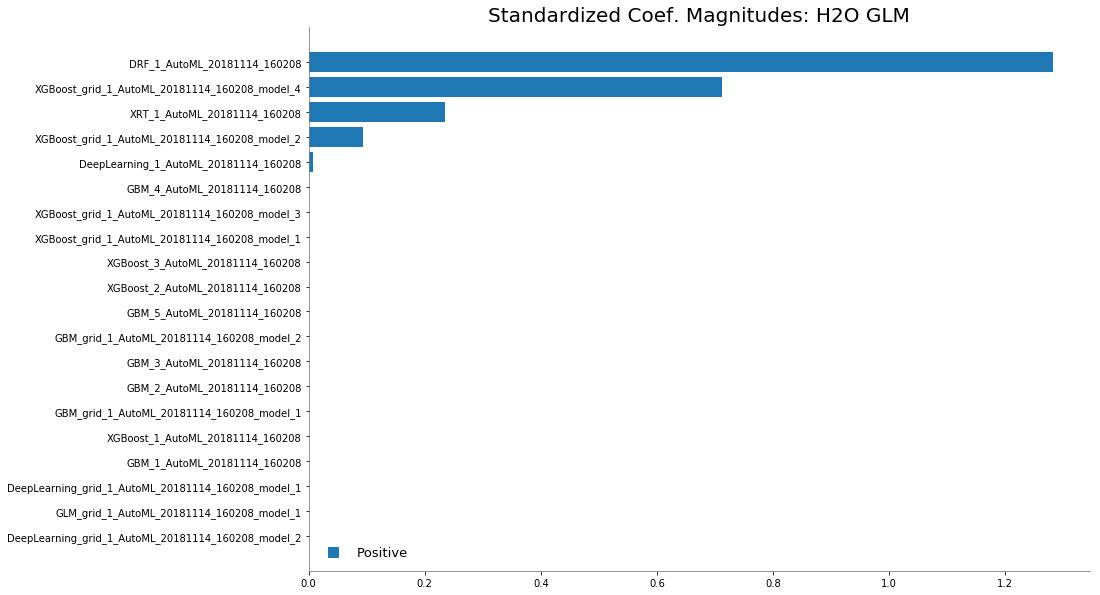

In [10]:
%matplotlib inline
metalearner.std_coef_plot()

In [11]:
h2o.save_model(aml.leader, path = "./product_model_bin/m20")

'/home/siemanalyst/notebooks/siem/product_model_bin/m20/StackedEnsemble_AllModels_AutoML_20181114_160208'

In [12]:
aml.leader.download_mojo(path = "./product_model_bin/m20/mojo")

'/home/siemanalyst/notebooks/siem/product_model_bin/m20/mojo'

In [14]:
sc.stop()